In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Embedding, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

import warnings
warnings.filterwarnings('ignore')


In [2]:
from google.colab import files

uploaded = files.upload()

Saving AmazonReview.csv to AmazonReview.csv


In [3]:
data = pd.read_csv('AmazonReview.csv')

# Printing shape of the dataset
print(data.shape)
# printing columns and rows information
print(data.info())


(25000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     24999 non-null  object
 1   Sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None


In [4]:
# looking for NULL values
print("Null Values:\n", data.isna().sum())

# dropping null values ONLY in the 'Review' column
data = data.dropna(subset=['Review'])  # <-- Change this line

# again checking for NULL values
print("Null Values after dropping:\n", data.isna().sum())

Null Values:
 Review       1
Sentiment    0
dtype: int64
Null Values after dropping:
 Review       0
Sentiment    0
dtype: int64


In [5]:
# count of unique values in Sentiment column
data['Sentiment'].value_counts()


,count
Sentiment,
1,5000
2,5000
3,5000
4,5000
5,4999


In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Review text Cleaning
def clean_reviews(text):
    # Handle non-string types
    if not isinstance(text, str):
        text = str(text)  # Convert to string if not already

    # removing html brackets and other square brackets from the string using regex
    regex = re.compile('<.*?>') # r'<.*?>'
    text = re.sub(regex, '', text)

    # removing special characters like @, #, $, etc
    pattern = re.compile('[^a-zA-z0-9\s]')
    text = re.sub(pattern,'',text)

    # removing numbers
    pattern = re.compile('\d+')
    text = re.sub(pattern,'',text)

    # converting text to lower case
    text = text.lower()

    # Tokenization of words
    text = word_tokenize(text)

    # Stop words removal
    text = [word for word in text if not word in stop_words]

    return text

# using the clean_reviews function on the dataset
data['Review'] = data['Review'].apply(clean_reviews)
data.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Review,Sentiment
0,"[fast, shipping, product, cheaply, made, broug...",1
1,"[case, takes, long, ship, even, worth, dont, buy]",1
2,"[good, droids, good, iphones, use, features, w...",1
3,"[cable, compatible, macbook, iphone, also, con...",1
4,"[case, nice, glow, light, im, disappointed, pr...",1


In [7]:
if 'Sentiment' in data.columns:
    tokenizer = Tokenizer()

    # converting all the reviews to list to pass it as a parameter to fit_on_texts
    reviews_to_list = data['Review'].tolist()
    tokenizer.fit_on_texts(reviews_to_list)

    # Generating text sequences
    text_sequences = tokenizer.texts_to_sequences(reviews_to_list)
    max_words = 500
    # Pad sequences to ensure consistent length
    # This step ensures all sequences have the same length, resolving the error
    text_sequences = pad_sequences(text_sequences, maxlen=max_words)

    # Now you can convert to a NumPy array
    text_sequences = np.array(text_sequences)

    data_encoded = data.copy()

    # one hot encoding on the copied DataFrame
    data_encoded = pd.get_dummies(data_encoded, columns = ['Sentiment'])

    # setting maximum words we want in an example
    max_words = 500

    # Generatin our X (input) to the model
    # using pad_sequences and y (output)
    X = text_sequences  # We already padded the sequences
    y = data_encoded[['Sentiment_1', 'Sentiment_2', 'Sentiment_3', 'Sentiment_4',
        'Sentiment_5']]
    print(X.shape, y.shape)
else:
    print("Error: 'Sentiment' column not found in DataFrame. Check your data processing steps.")

(24999, 500) (24999, 5)


In [8]:
# Train Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(19999, 500) (5000, 500) (19999, 5) (5000, 5)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential(name="LSTM_Model")
vocab_size = len(tokenizer.word_index) + 1

# Adding an embedding layer
model.add(Embedding(vocab_size,
                    max_words,
                    input_length=max_words))

# Changing the Bidirectional LSTM layer to 64 units
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.5))

# Dense layer with 32 hidden units and ReLU activation (adjusted from 64)
model.add(Dense(32, activation='relu'))

# Output layer for sentiment classification
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Build the model to calculate output shapes
model.build(input_shape=(None, max_words))

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Print model summary
print(model.summary())


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 500, 500)            │      19,819,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         289,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,113,073 (76.73 MB)

 Trainable params: 20,113,073 (76.73 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Compiling the model
model.compile(
	loss="categorical_crossentropy",
	optimizer='adam',
	metrics=['accuracy']
)

# Training the GRU model
history = model.fit(X_train, y_train,
						batch_size=64,
						epochs=8,
						verbose=1,
					validation_data=(X_test, y_test))

# Printing model score on test data
print("LSTM model Score---> ", model.evaluate(X_test, y_test, verbose=1))


Epoch 1/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 78ms/step - accuracy: 0.3231 - loss: 1.4765 - val_accuracy: 0.4696 - val_loss: 1.2047
Epoch 2/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 75ms/step - accuracy: 0.5632 - loss: 1.0487 - val_accuracy: 0.4626 - val_loss: 1.2391
Epoch 3/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 78ms/step - accuracy: 0.6794 - loss: 0.8246 - val_accuracy: 0.4606 - val_loss: 1.3666
Epoch 4/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.7668 - loss: 0.6360 - val_accuracy: 0.4460 - val_loss: 1.5820
Epoch 5/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.8312 - loss: 0.4875 - val_accuracy: 0.4412 - val_loss: 1.7626
Epoch 6/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.8668 - loss: 0.3795 - val_accuracy: 0.4370 - val_loss: 2.0143
Epoch 7/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.8882 - loss: 0.3188 - val_accuracy: 0.4276 - val_loss: 2.1528
Epoch 8/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.9113 - loss: 0.2515 - val_accu

Text(0, 0.5, 'Accuracy')

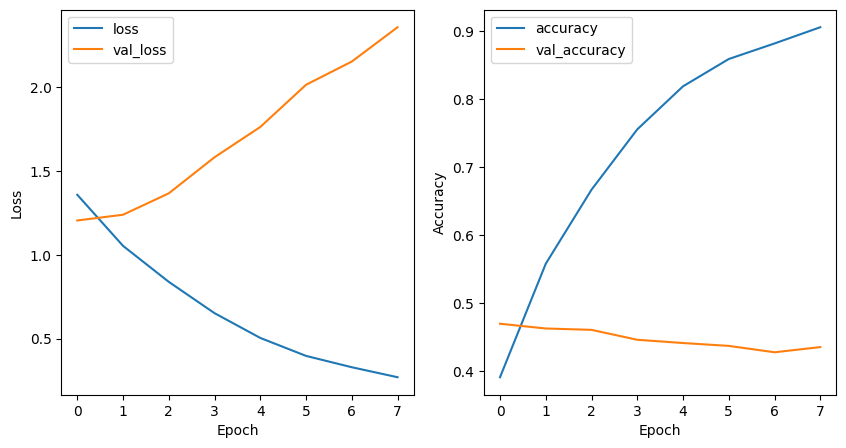

In [ ]:
# Plotting the history
metrics = history.history
plt.figure(figsize=(10, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'],
		metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


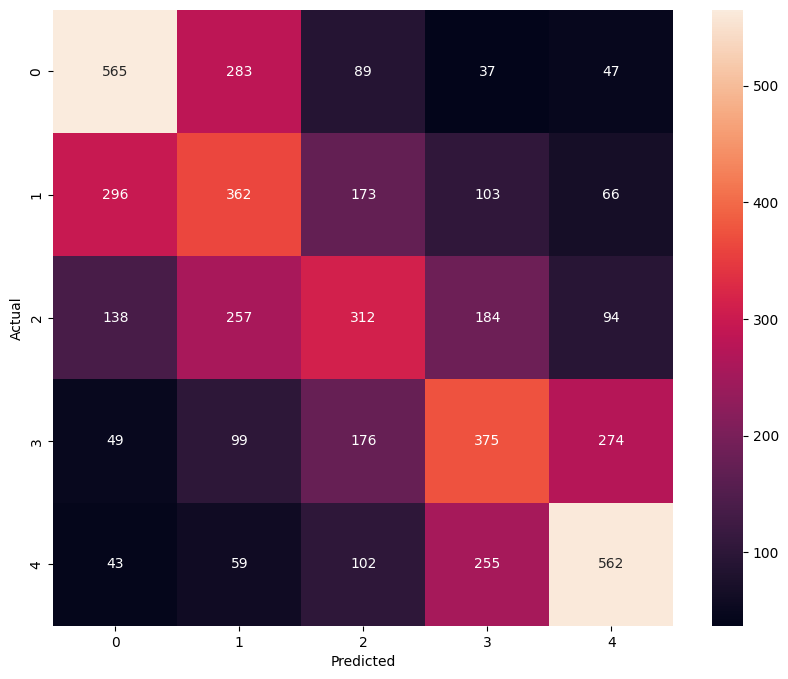

In [ ]:
# converting y_test tht was one hot encoded to one column fo rconfusion matrix
y_true = np.argmax(y_test.values, axis=1)
y_true.shape

# Confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = tf.math.confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# RNN

In [9]:
# Creating a RNN model
vocab_size = len(tokenizer.word_index) + 1  # Calculate vocabulary size
# Initialize the model
rnn = Sequential(name="Enhanced_RNN")

# Embedding layer
rnn.add(Embedding(vocab_size, max_words, input_length=max_words))

# First SimpleRNN layer
rnn.add(SimpleRNN(128, activation='relu', return_sequences=True))

# Dropout layer for regularization
rnn.add(Dropout(0.5))

# Second SimpleRNN layer
rnn.add(SimpleRNN(128, activation='relu', return_sequences=True))

# Dropout layer for regularization
rnn.add(Dropout(0.5))

# Third SimpleRNN layer
rnn.add(SimpleRNN(64, activation='relu', return_sequences=False))

# Fully connected layer
rnn.add(Dense(64, activation='relu'))

# Output layer
rnn.add(Dense(5, activation='softmax'))


# Build the model (this will calculate output shapes)
rnn.build(input_shape=(None, max_words))  # Replace None with your batch size if known

# printing model summary
print(rnn.summary())

Model: "Enhanced_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 500, 500)            │      19,819,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 500, 128)            │          80,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 500, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 500, 128)            │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,949,745 (76.10 MB)

 Trainable params: 19,949,745 (76.10 MB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
# Compiling model
rnn.compile(
	loss="categorical_crossentropy",
	optimizer='adam',
	metrics=['accuracy']
)

# Training the model
history = rnn.fit(X_train, y_train,
						batch_size=64,
						epochs=8,
						verbose=1,
						validation_data = (X_test, y_test))

# Printing model score on test data
print("Simple_RNN Score---> ", rnn.evaluate(X_test, y_test, verbose=1))


Epoch 1/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 72s 202ms/step - accuracy: 0.2297 - loss: 1.5853 - val_accuracy: 0.4048 - val_loss: 1.3135
Epoch 2/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 180ms/step - accuracy: 0.4334 - loss: 1.2516 - val_accuracy: 0.3824 - val_loss: 1.3030
Epoch 3/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 180ms/step - accuracy: 0.5168 - loss: 1.0713 - val_accuracy: 0.4346 - val_loss: 1.3123
Epoch 4/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 183ms/step - accuracy: 0.6231 - loss: 0.9004 - val_accuracy: 0.4352 - val_loss: 1.3681
Epoch 5/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 180ms/step - accuracy: 0.6846 - loss: 0.7684 - val_accuracy: 0.4114 - val_loss: 1.4726
Epoch 6/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 182ms/step - accuracy: 0.7490 - loss: 0.6438 - val_accuracy: 0.4232 - val_loss: 1.6584
Epoch 7/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 63s 201ms/step - accuracy: 0.7933 - loss: 0.5393 - val_accuracy: 0.4200 - val_loss: 1.8454
Epoch 8/8
313/313 ━━━━━━━━━━━━━━━━━━━━ 75s 180ms/step - accuracy: 0.8260 - loss: 0.4607 - 

Text(0, 0.5, 'Accuracy')

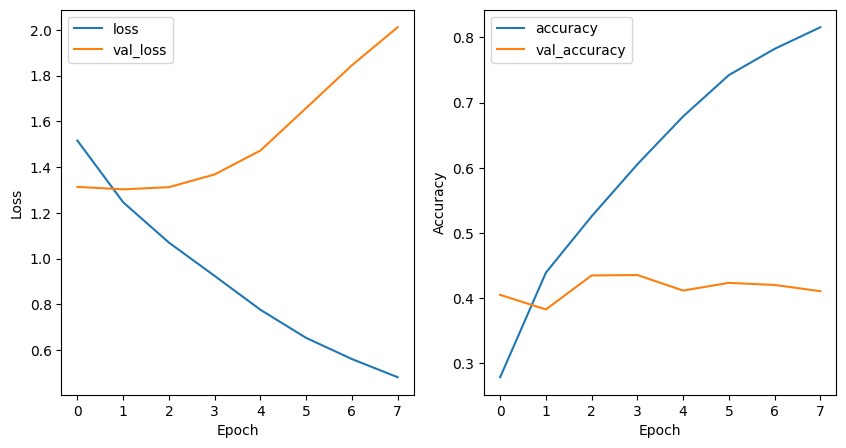

In [11]:
# Plotting the history
metrics = history.history
plt.figure(figsize=(10, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'],
		metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step


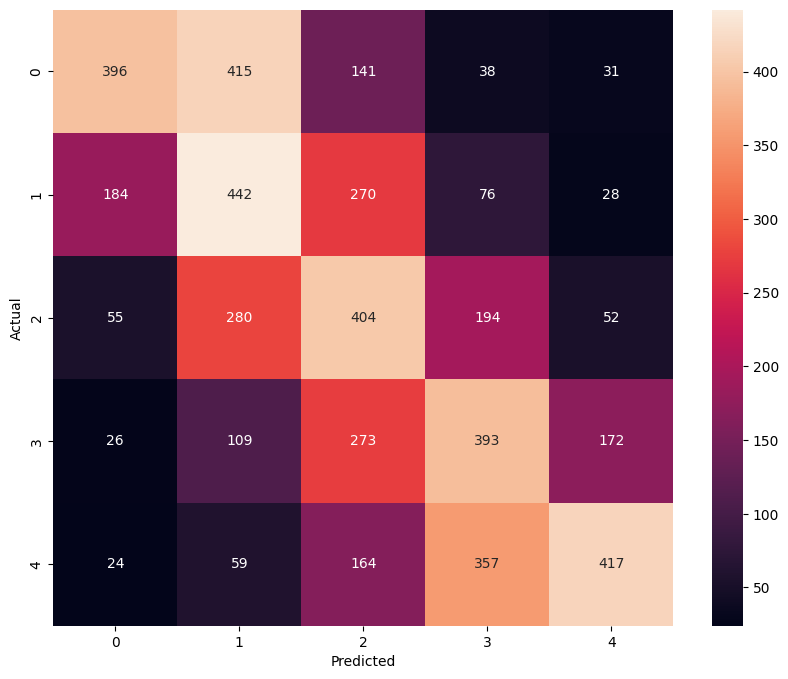

In [12]:
# converting y_test tht was one hot encoded to one column fo rconfusion matrix
y_true = np.argmax(y_test.values, axis=1)
y_true.shape

# Confusion matrix
y_pred = np.argmax(rnn.predict(X_test), axis=1)
cm = tf.math.confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [13]:


from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.58      0.39      0.46      1021
           1       0.34      0.44      0.38      1000
           2       0.32      0.41      0.36       985
           3       0.37      0.40      0.39       973
           4       0.60      0.41      0.48      1021

    accuracy                           0.41      5000
   macro avg       0.44      0.41      0.42      5000
weighted avg       0.44      0.41      0.42      5000



In [15]:
def predict_review_rating(text):
    # Indent the code within the function
    text_sequences_test = np.array(tokenizer.texts_to_sequences([text])) # Add [text] to process the input
    testing = pad_sequences(text_sequences_test, maxlen = max_words)
    y_pred_test = np.argmax(rnn.predict(testing), axis=1) # Change model to rnn
    return y_pred_test[0]+1

# Testing
rating1 = predict_review_rating('Worst product')
print("The rating according to the review is: ", rating1)

rating2 = predict_review_rating('Awesome product, I will recommend this to other users.')
print("The rating according to the review is: ", rating2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step
The rating according to the review is:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
The rating according to the review is:  5
